# 11.6 Практическая работа 

самостоятельно проектировать эксперимент,

выбирать метрики и показатели для трекинга во время эксперимента,

запускать эксперименты на MLflow.


## План ноутбука:

1. Вводные по задаче.

2. Библиотеки.

3. Блок функций.

4. Загрузка данных.

5. Первоначальный скрипт.

6. Research.

7. Final model

8. MLflow Эксперементы.

9. Результаты и выводы.

## Вводные по задаче.

Что нужно сделать

Используйте датасет.

Вы получили от коллеги скрипт, который нужно привести в порядок. Это скрипт, который тренирует самую простую ML-модель на датасете (вы решаете задачу классификации отзывов о фильме: позитивный отзыв или негативный). Только он не соответствует лучшим практикам работы с ML-артефактами. Где полученная модель — непонятно, какие у неё метрики — тоже.

Ваша задача — привести скрипт в порядок:

    Установить зависимости для скрипта:

pip install pandas numpy scikit-learn nltk

    Добавить его в репозиторий из предыдущей задачи.
    Добавить в скрипт MLflow Tracking для логирования результатов и провести эксперимент.
    Добавить ещё один скрипт с альтернативной моделью (любой на ваше усмотрение) и запустить его.
    Сравнить результаты двух экспериментов в MLflow web UI, предоставить скриншоты и указать, какая модель показывает лучшие результаты на выбранных метриках.
    Закоммитить все обновлённые скрипты, артефакты моделей и логи их запусков.

import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
import nltk
from nltk.corpus import stopwords
import re

#### Download Russian stopwords
nltk.download('stopwords')
russian_stopwords = set(stopwords.words('russian'))


#### Load the JSONL file
def load_jsonl(file_path):
   data = []
   with open(file_path, 'r', encoding='utf-8') as f:
       for line in f:
           data.append(json.loads(line))
   return pd.DataFrame(data)

#### Preprocess text
def preprocess_text(text):
   #### Convert to lowercase
   text = text.lower()
   #### Remove punctuation
   text = re.sub(r'[^\w\s]', '', text)
   #### Remove stopwords
   words = text.split()
   words = [word for word in words if word not in russian_stopwords]
   return ' '.join(words)

#### Load the data
df = load_jsonl('kinopoisk.jsonl')

#### Preprocess the content
df['processed_content'] = df['content'].apply(preprocess_text)

#### Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
   df['processed_content'], df['grade3'], test_size=0.2, random_state=42
)

#### Create bag of words representation
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

#### Train the classifier
clf = MultinomialNB()
clf.fit(X_train_bow, y_train)

#### Make predictions
y_pred = clf.predict(X_test_bow)

#### Evaluate the model
print(classification_report(y_test, y_pred))


#### Function to classify new reviews
def classify_review(review_text):
   processed_text = preprocess_text(review_text)
   bow_representation = vectorizer.transform([processed_text])
   prediction = clf.predict(bow_representation)
   return prediction[0]

#### Example usage
#example_review = "Ваш текст рецензии на русском языке"
#print(f"Классификация: {classify_review(example_review)}")

## Библиотеки.

In [ ]:
import json
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import argparse  # Import the argparse module
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, roc_curve, auc
import nltk
from nltk.corpus import stopwords
import re
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
from tqdm import tqdm
import pymorphy2 # поддерживает русский
from nltk.tokenize import word_tokenize
import spacy
import spacy.cli
from gensim.models import Word2Vec
import torchtext.data as data
from torchtext.data import Field, LabelField
from torchtext.data import BucketIterator
from imblearn.under_sampling import RandomUnderSampler



In [2]:
# Download Russian stopwords
nltk.download('punkt')
nltk.download('stopwords')
russian_stopwords = set(stopwords.words('russian'))

# Загрузка модели для русского языка
nlp = spacy.load("ru_core_news_sm")
# Загрузка стоп-слов для русского языка
stop_words = set(stopwords.words('russian'))

# Инициализация лемматизатора для русского языка
# morph = pymorphy2.MorphAnalyzer()

# Загрузка стоп-слов для русского языка
stop_words = set(stopwords.words('russian'))

#!python3 -m spacy download ru_core_news_sm

[nltk_data] Downloading package punkt to
[nltk_data]     /home/leostuchchi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/leostuchchi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Проверка доступности GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Используемое устройство: {device}")

# Загрузка необходимых ресурсов
nltk.download('punkt')
nltk.download('stopwords')
russian_stopwords = set(stopwords.words('russian'))

spacy.cli.download("ru_core_news_sm")

# Загрузка модели для русского языка
nlp = spacy.load("ru_core_news_sm")

# Загрузка предобученной модели и токенизатора
model_name = "DeepPavlov/rubert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)  # Перемещаем модель на GPU

Используемое устройство: cpu


[nltk_data] Downloading package punkt to
[nltk_data]     /home/leostuchchi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/leostuchchi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 6.0 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Блок функций.

In [4]:
# spacy очистка и лемматизация

def text_cleaner_lemmatizer(text):
    # Преобразование текста в нижний регистр
    text = text.lower()

    # Удаление лишних пробелов
    text = re.sub(r'\s+', ' ', text)

    # Удаление знаков препинания
    text = re.sub(r'[^\w\s]', '', text)

    # Обработка текста с помощью spacy
    doc = nlp(text)

    # Удаление стоп-слов и лемматизация
    cleaned_text = " ".join([token.lemma_ for token in doc if token.text.lower() not in stop_words])

    return cleaned_text

In [5]:
def cleaner_lemmatizer(text):
    # Преобразование текста в нижний регистр
    text = text.lower()

    # Удаление лишних пробелов
    text = re.sub(r'\s+', ' ', text)

    # Удаление знаков препинания (для русского языка)
    text = re.sub(r'[^\w\s]', '', text)

    # Токенизация текста
    tokens = word_tokenize(text, language='russian')

    # Удаление стоп-слов
    filtered_text = [word for word in tokens if word.lower() not in stop_words]

    # Лемматизация слов
    lemmatized_text = [morph.parse(word)[0].normal_form for word in filtered_text]

    # Объединение лемматизированных слов обратно в текст
    cleaned_text = ' '.join(lemmatized_text)

    return cleaned_text




# Load the JSONL file
def load_jsonl(file_path):
   data = []
   with open(file_path, 'r', encoding='utf-8') as f:
       for line in f:
           data.append(json.loads(line))
   return pd.DataFrame(data)

# Preprocess text
def preprocess_text(text):
   # Convert to lowercase
   text = text.lower()
   # Remove punctuation
   text = re.sub(r'[^\w\s]', '', text)
   # Remove stopwords
   words = text.split()
   words = [word for word in words if word not in russian_stopwords]
   return ' '.join(words)

# Препроцессинг текста
def preprocess_text(text):
    # Приведение к нижнему регистру
    text = text.lower()
    # Удаление цифр
    text = re.sub(r'\d+', '', text)
    # Удаление знаков препинания
    text = re.sub(r'[^\w\s]', '', text)
    # Удаление стоп-слов
    words = text.split()
    words = [word for word in words if word not in russian_stopwords]
    return ' '.join(words)


# Function to classify new reviews
def classify_review(review_text):
   processed_text = preprocess_text(review_text)
   bow_representation = vectorizer.transform([processed_text])
   prediction = clf.predict(bow_representation)
   return prediction[0]

In [6]:
# Вывод метрик и confusion_matrix
def metrix(classifier,test_df, test_y):
    predictions = classifier.predict(test_df)
    prec = precision_score(test_y, predictions, average='micro')
    print(prec)
    cm = confusion_matrix(test_y, predictions, labels=classifier.classes_, normalize='all')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=classifier.classes_)
    disp.plot()
    plt.show()

    return prec, disp

In [7]:
# Для БИНАРНОЙ

# Вычисляем accuracy
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

# Обучение
def train(model, iterator, optimizer, criterion): # обучение одной эпохи 
    epoch_loss = 0
    epoch_acc = 0
    model.train()

    all_predictions = []
    all_labels = []

    for batch in iterator:
        optimizer.zero_grad()
        predictions = model(batch.text).squeeze(1)
        #loss = criterion(predictions, batch.label)
        loss = criterion(predictions, batch.label.long())
        acc = binary_accuracy(predictions, batch.label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

        all_predictions += predictions.tolist()
        all_labels += batch.label.tolist()

    all_predictions = torch.tensor(all_predictions)
    all_labels = torch.tensor(all_labels)
    val_acc = binary_accuracy(all_predictions, all_labels)
    val_loss = criterion(all_predictions, all_labels).item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator), val_loss, val_acc.item()


# Вычисление метрик + ROC кривая
def evaluate_model(model, iterator):
    all_predictions = []
    all_labels = []

    for batch in tqdm(iterator):
        predictions = model(batch.text).squeeze(1)
        all_predictions += predictions.tolist()
        all_labels += batch.label.tolist()

    all_predictions = torch.tensor(all_predictions)
    all_labels = torch.tensor(all_labels)

    y_pred_binary = torch.round(torch.sigmoid(all_predictions)).cpu().numpy()
    y_true = all_labels.cpu().numpy()

    accuracy = accuracy_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    roc_auc = roc_auc_score(y_true, all_predictions.cpu().numpy())

    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("ROC AUC Score:", roc_auc)

    fpr, tpr, _ = roc_curve(y_true, all_predictions.cpu().numpy())
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# metrix
def metrix_model(model, iterator):
    all_predictions = []
    all_labels = []

    for batch in tqdm(iterator):
        predictions = model(batch.text).squeeze(1)
        all_predictions += predictions.tolist()
        all_labels += batch.label.tolist()

    all_predictions = torch.tensor(all_predictions)
    all_labels = torch.tensor(all_labels)

    y_pred_binary = torch.round(torch.sigmoid(all_predictions)).cpu().numpy()
    y_true = all_labels.cpu().numpy()

    accuracy = accuracy_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    roc_auc = roc_auc_score(y_true, all_predictions.cpu().numpy())

    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("ROC AUC Score:", roc_auc)

    


In [8]:
# ДЛЯ МНОГОКЛАССОВО УКАЗЫВАЕМ КОЛИЧЕСТВО КЛАССОВ

# Вычисляем accuracy для трех классов
def categorical_accuracy(preds, y):
    max_preds = preds.argmax(dim=1, keepdim=True)  # Получаем индекс класса с наибольшей вероятностью
    correct = max_preds.squeeze(1) == y
    acc = correct.sum() / torch.FloatTensor([y.shape[0]])
    return acc

# Обучение
def train(model, iterator, optimizer, criterion, device, num_classes):
    epoch_loss = 0
    epoch_acc = 0
    model.train()  # Переводим модель в режим обучения

    for batch in tqdm(iterator):
        optimizer.zero_grad()  # Обнуляем градиенты
        
        text = batch.text.to(device)  # Переносим текст на устройство
        labels = batch.label.to(device)  # Переносим метки на устройство

        # Проверяем, что все метки в нужном диапазоне
        if torch.any((labels < 0) | (labels >= num_classes)):
            print("Метки вне диапазона!")
            continue  # Пропускаем этот батч
        
        predictions = model(text)  # Получаем предсказания модели
        
        loss = criterion(predictions, labels.long())  # Преобразуем метки в Long
        acc = categorical_accuracy(predictions, labels)  # Вычисляем точность
        
        loss.backward()  # Вычисляем градиенты
        optimizer.step()  # Обновляем параметры модели
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Оценка
def evaluate(model, iterator, criterion, device, num_classes):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()  # Переводим модель в режим оценки

    with torch.no_grad():  # Отключаем вычисление градиентов
        for batch in tqdm(iterator):
            text = batch.text.to(device)  # Переносим текст на устройство
            labels = batch.label.to(device)  # Переносим метки на устройство
            
            # Проверяем, что все метки в нужном диапазоне
            if torch.any((labels < 0) | (labels >= num_classes)):
                print("Метки вне диапазона!")
                continue  # Пропускаем этот батч

            predictions = model(text)  # Получаем предсказания модели
            
            loss = criterion(predictions, labels.long())  # Преобразуем метки в Long
            acc = categorical_accuracy(predictions, labels)  # Вычисляем точность

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def metrix_model(model, iterator, device, num_classes):
    model.eval()  # Переводим модель в режим оценки
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(iterator, desc="Metrics Calculation"):
            text = batch.text.to(device)  # Переносим текст на устройство
            labels = batch.label.to(device)  # Переносим метки на устройство
            
            # Проверяем, что все метки в нужном диапазоне
            if torch.any((labels < 0) | (labels >= num_classes)):
                print("Метки вне диапазона!")
                continue  # Пропускаем этот батч

            predictions = model(text)  # Получаем предсказания модели
            all_predictions.append(predictions.cpu().numpy())  # Сохраняем предсказания
            all_labels.append(labels.cpu().numpy())  # Сохраняем метки

    # Конвертируем списки в numpy массивы
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Преобразуем вероятности в предсказанные классы
    predicted_classes = np.argmax(all_predictions, axis=1)

    # Вычисляем accuracy и F1-score
    accuracy = accuracy_score(all_labels, predicted_classes)
    f1 = f1_score(all_labels, predicted_classes, average='weighted')  # Используем 'weighted' для учета дисбаланса классов

    print("Accuracy:", accuracy)
    print("F1 Score:", f1)

    # Вычисляем ROC AUC score для каждого класса (One-vs-Rest)
    roc_auc_scores = []
    for i in range(num_classes):
        try:
            roc_auc = roc_auc_score(all_labels == i, all_predictions[:, i])
            roc_auc_scores.append(roc_auc)
            print(f"ROC AUC Score (Class {i}):", roc_auc)
        except ValueError:
            print(f"Невозможно вычислить ROC AUC Score для класса {i} из-за отсутствия одного из классов в данных.")
            roc_auc_scores.append(np.nan)  # Или другое значение по умолчанию

    # Рисуем ROC кривую для каждого класса
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        if not np.isnan(roc_auc_scores[i]):
            fpr, tpr, _ = roc_curve(all_labels == i, all_predictions[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'ROC curve (Class {i}, area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) - Multiclass')
    plt.legend(loc='lower right')
    plt.show()




## Загрузка данных

In [9]:
#df = pd.read_json("hf://datasets/blinoff/kinopoisk/kinopoisk.jsonl", lines=True)
#df.to_json('kinopoisk.jsonl')

In [10]:
# Load the data
#df = load_jsonl('kinopoisk.jsonl')

In [11]:
df = pd.read_json('kinopoisk.jsonl')

In [12]:
df.isna().sum()

part             0
movie_name       0
review_id        0
author         789
date             0
title         9119
grade3           0
grade10          0
content          0
dtype: int64

In [13]:
df.dtypes

part                  object
movie_name            object
review_id              int64
author                object
date          datetime64[ns]
title                 object
grade3                object
grade10              float64
content               object
dtype: object

In [14]:
df.shape

(36591, 9)

In [15]:
df = pd.DataFrame(df)

In [16]:
df

,part,movie_name,review_id,author,date,title,grade3,grade10,content
0,top250,Блеф (1976),17144,Come Back,2011-09-24,Плакали наши денежки ©,Good,10.0,"\n""Блеф» — одна из моих самых любимых комедий...."
1,top250,Блеф (1976),17139,Stasiki,2008-03-04,None,Good,0.0,\nАдриано Челентано продолжает радовать нас св...
2,top250,Блеф (1976),17137,Flashman,2007-03-04,None,Good,10.0,"\nНесомненно, это один из великих фильмов 80-х..."
3,top250,Блеф (1976),17135,Sergio Tishin,2009-08-17,""" Черное, красное, ерунда это все. Выигрывает ...",Good,0.0,\nЭта фраза на мой взгляд отражает сюжет несом...
4,top250,Блеф (1976),17151,Фюльгья,2009-08-20,"«Он хотел убежать? Да! Блеф, блеф…»",Neutral,7.0,"\n- как пела Земфира, скорее всего, по соверше..."
...,...,...,...,...,...,...,...,...,...
36586,bottom100,Цветок дьявола (2010),25123,bestiya163,2010-09-23,"Ой, ой, ой!",Bad,2.0,\n Ну с чего бы начать… Давненько я не пи...
36587,bottom100,Цветок дьявола (2010),25192,Молка,2010-10-02,Молчаливый мужик на коне…,Bad,1.0,"\n Можно начать с того, что уже постер к ..."
36588,bottom100,Цветок дьявола (2010),25080,jetry,2010-09-16,Это проявилось сегодня ночью.,Good,7.0,"\n Фильм производства России, поэтому мно..."
36589,bottom100,Цветок дьявола (2010),25088,Alkort,2010-09-16,«Finita la comedia»,Bad,0.0,\n 16 сентября на большие экраны вышел «м...


In [17]:
df['content'][0]

'\n"Блеф»\xa0—\xa0одна из\xa0моих самых любимых комедий.\n\nЭтот фильм я\xa0наверно смотрел раз\xa0сто, нет\xa0я конечно блефую, я\xa0видел его\xa0куда больше. Не\xa0могу не\xa0выразить своё восхищение главными действующими лицами этого фильма. Начну с\xa0Адриано Челентано для\xa0которого как\xa0я считаю это\xa0лучшая роль в\xa0кино. Великолепный актёр, неплохой певец, странно что\xa0на его\xa0родине в\xa0Италии его\xa0песни мало кто\xa0слушает. Ну\xa0я думаю что\xa0и итальянцы и\xa0французы привыкли к\xa0тому, что\xa0у нас\xa0до сих\xa0их актёры популярней чем\xa0даже на\xa0своей родине. Да, такой вот\xa0парадокс. Челентано конечно профессионал своего дела, комик с\xa0серьёзным выражением лица. Он\xa0смешон ещё\xa0и потому, что\xa0одновременно так\xa0серъёзен. Адриано браво!\n\nА\xa0теперь несколько слов об\xa0Энтони Куине. Да\xa0тот самый горбун из\xa0Нотр-дама. Собор Парижской Богоматери, оригинальная версия, кто\xa0не смотрел рекомендую. С\xa0ним как-то приключилась одна интересная

## Полученый скрипт.

In [26]:
df = pd.read_json('kinopoisk.jsonl')

In [27]:
# Preprocess the content
df['processed_content'] = df['content'].apply(preprocess_text)

In [28]:
# Split the data into train and test sets
X_train, X_test, y_train_f, y_test_f = train_test_split(
   df['processed_content'], df['grade3'], test_size=0.2, random_state=42
)

In [29]:
# Create bag of words representation
vectorizer = CountVectorizer()
X_train_bow_f = vectorizer.fit_transform(X_train)
X_test_bow_f = vectorizer.transform(X_test)

In [30]:
X_train_bow_f.shape

(29272, 261448)

In [31]:
# Train the classifier
clf = MultinomialNB()
clf.fit(X_train_bow_f, y_train_f)

MultinomialNB()

In [32]:
# Make predictions
y_pred_f = clf.predict(X_test_bow_f)

# Evaluate the model
print(classification_report(y_test_f, y_pred_f))

              precision    recall  f1-score   support

         Bad       0.63      0.66      0.64       979
        Good       0.84      0.97      0.90      5412
     Neutral       0.38      0.02      0.03       928

    accuracy                           0.81      7319
   macro avg       0.62      0.55      0.52      7319
weighted avg       0.75      0.81      0.76      7319



## Research.

Кодирование целевого признака.

Бинарный целевой признак, согласно условиям задачи.

Моделирование.

### Изменение первоначального скрипта.

In [35]:
df = pd.read_json('kinopoisk.jsonl')

# Preprocess the content
df['processed_content'] = df['content'].apply(preprocess_text)
# Закодируем признак grade3
# Удаление строк с меткой 'Neutral'
df = df[df['grade3'] != 'Neutral']
# Преобразование значений в 'grade2'
df['grade2'] = df['grade3'].map({'Bad': 0, 'Good': 1})
print('grade2', df['grade2'].value_counts())
target_dict = {'Bad': 0, 'Good': 1}

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
   df['processed_content'], df['grade2'], test_size=0.2, random_state=42
)

grade2 1    27264
0     4751
Name: grade2, dtype: int64


In [36]:
# Create bag of words representation
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

In [37]:
X_train_bow.shape

(25612, 242473)

In [38]:
# Train the classifier
clf = MultinomialNB()
clf.fit(X_train_bow, y_train)

MultinomialNB()

In [39]:
# Make predictions
y_pred = clf.predict(X_test_bow)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.69      0.74       935
           1       0.95      0.97      0.96      5468

    accuracy                           0.93      6403
   macro avg       0.87      0.83      0.85      6403
weighted avg       0.93      0.93      0.93      6403



In [40]:
# Вывод метрик и confusion_matrix
def metrix(classifier,test_df, test_y):
    predictions = classifier.predict(test_df)
    prec = precision_score(test_y, predictions, average='micro')
    print(prec)
    cm = confusion_matrix(test_y, predictions, labels=classifier.classes_, normalize='all')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=classifier.classes_)
    disp.plot()
    plt.show()

    return prec, disp

0.9287833827893175


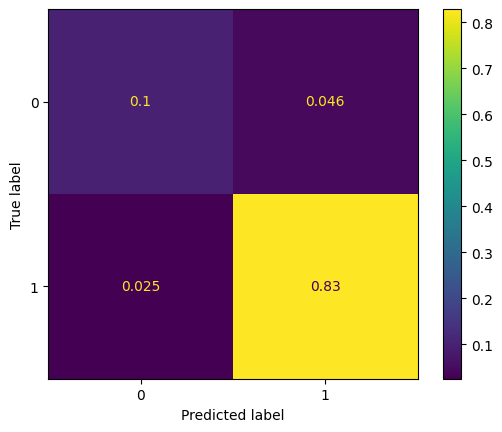

{'Bad': 0, 'Good': 1}

In [41]:
prec, disp =  metrix(clf, X_test_bow, y_test)
target_dict

### Моделирование

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
# Train the classifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train_bow, y_train)

GradientBoostingClassifier()

              precision    recall  f1-score   support

           0       0.89      0.31      0.46       935
           1       0.89      0.99      0.94      5468

    accuracy                           0.89      6403
   macro avg       0.89      0.65      0.70      6403
weighted avg       0.89      0.89      0.87      6403

0.8936436045603623


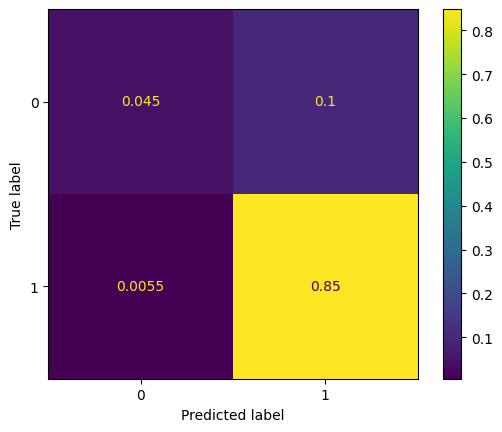

In [ ]:
# Make predictions
y_pred = gbc.predict(X_test_bow)

# Evaluate the model
print(classification_report(y_test, y_pred))
prec, disp =  metrix(gbc, X_test_bow, y_test)

              precision    recall  f1-score   support

           0       0.87      0.75      0.81       935
           1       0.96      0.98      0.97      5468

    accuracy                           0.95      6403
   macro avg       0.91      0.87      0.89      6403
weighted avg       0.95      0.95      0.95      6403

0.9473684210526315


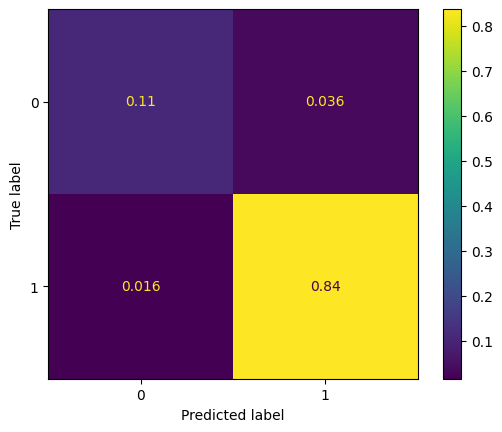

In [ ]:


# Train the classifier
logreg = LogisticRegression()
logreg.fit(X_train_bow, y_train)

# Make predictions
y_pred = logreg.predict(X_test_bow)

# Evaluate the model
print(classification_report(y_test, y_pred))

prec, disp =  metrix(logreg, X_test_bow, y_test)

[LightGBM] [Info] Number of positive: 21796, number of negative: 3816
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 21.911036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 74807
[LightGBM] [Info] Number of data points in the train set: 25612, number of used features: 24402
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.851007 -> initscore=1.742524
[LightGBM] [Info] Start training from score 1.742524
              precision    recall  f1-score   support

         0.0       0.88      0.64      0.74       935
         1.0       0.94      0.99      0.96      5468

    accuracy                           0.93      6403
   macro avg       0.91      0.81      0.85      6403
weighted avg       0.93      0.93      0.93      6403

0.9342495705138216


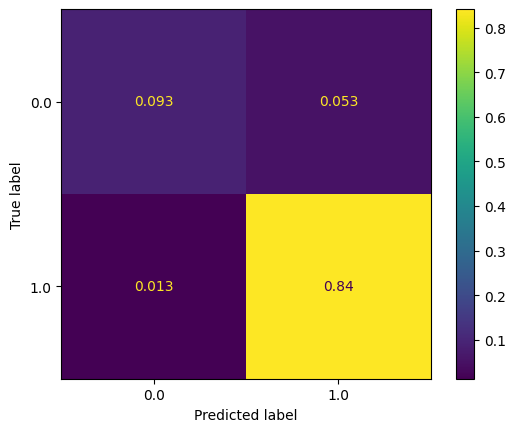

In [ ]:
from lightgbm import LGBMClassifier

# Train the classifier
lgbm = LGBMClassifier()
# Преобразование данных в нужный формат
X_train_np = X_train_bow.astype(np.float32)  # или np.float64, если необходимо
y_train_np = y_train.astype(np.float32)  # или np.float64, если необходимо
X_test_np = X_test_bow.astype(np.float32)  # или np.float64, если необходимо
y_test_np = y_test.astype(np.float32)  # или np.float64, если необходимо

lgbm.fit(X_train_np, y_train_np)

# Make predictions
y_pred = lgbm.predict(X_test_np)

# Evaluate the model
print(classification_report(y_test_np, y_pred))

prec, disp =  metrix(lgbm, X_test_np, y_test_np)

              precision    recall  f1-score   support

           0       0.45      0.01      0.01       935
           1       0.85      1.00      0.92      5468

    accuracy                           0.85      6403
   macro avg       0.65      0.50      0.47      6403
weighted avg       0.80      0.85      0.79      6403

0.8538185225675464


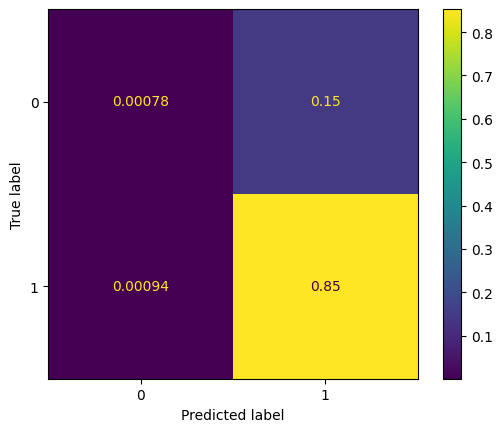

In [ ]:
from sklearn.neighbors import KNeighborsClassifier


# Train the classifier
knn = KNeighborsClassifier()
knn.fit(X_train_bow, y_train)

# Make predictions
y_pred = knn.predict(X_test_bow)

# Evaluate the model
print(classification_report(y_test, y_pred))

prec, disp =  metrix(knn, X_test_bow, y_test)

In [ ]:
# Example usage
#example_review = "Ваш текст рецензии на русском языке"
#print(f"Классификация: {classify_review(example_review)}")

### Word2Wec

использовать весь набор данных для обучения. Это связано с тем, что Word2Vec использует контекст слов для обучения векторных представлений, и чем больше данных он видит, тем лучше получаются векторы.

In [ ]:
df = pd.read_json('kinopoisk.jsonl')

# Preprocess the content
df['processed_content'] = df['content'].apply(preprocess_text)
# Закодируем признак grade3
# Удаление строк с меткой 'Neutral'
df = df[df['grade3'] != 'Neutral']
# Преобразование значений в 'grade2'
df['grade2'] = df['grade3'].map({'Bad': 0, 'Good': 1})
print('grade2', df['grade2'].value_counts())
target_dict = {'Bad': 0, 'Good': 1}

grade3 1    27264
0     4751
Name: grade3, dtype: int64


In [ ]:
# Обучение модели Word2Vec
sentences = [row.split() for row in df['processed_content']]  # Разделяем текст на слова
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

### ПРостые модели

In [ ]:
# Функция для создания векторного представления текста
def text_to_vector(text, model):
    words = text.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)  # Если ни одно слово не найдено, возвращаем нулевой вектор
    return np.mean(word_vectors, axis=0)

# Создание векторных представлений для всех текстов
X = np.array([text_to_vector(text, w2v_model) for text in df['processed_content']])

In [ ]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, df['grade2'], test_size=0.2, random_state=42)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Обучение модели
model = LogisticRegression()
model.fit(X_train, y_train)

# Прогнозирование
y_pred = model.predict(X_test)

# Оценка модели
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.59      0.66       935
           1       0.93      0.97      0.95      5468

    accuracy                           0.91      6403
   macro avg       0.84      0.78      0.80      6403
weighted avg       0.90      0.91      0.91      6403

Accuracy: 0.9106668749023895


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Обучение модели
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Прогнозирование
y_pred = model.predict(X_test)

# Оценка модели
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.40      0.53       935
           1       0.90      0.98      0.94      5468

    accuracy                           0.90      6403
   macro avg       0.85      0.69      0.73      6403
weighted avg       0.89      0.90      0.88      6403

Accuracy: 0.8966109636108074


### UnderSamp

In [ ]:
under = RandomUnderSampler(sampling_strategy='majority', random_state=42)  # уменьшаем количество экземпляров большинства

# Применяем Pipeline на обучающей выборке
X_train, y_train = under.fit_resample(X_train, y_train)

In [ ]:
y_train.value_counts()

0    3816
1    3816
Name: grade3, dtype: int64

In [ ]:
X_train.shape

(7632, 100)

In [ ]:
# Обучение модели
model = LogisticRegression()
model.fit(X_train, y_train)

# Прогнозирование
y_pred = model.predict(X_test)

# Оценка модели
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.90      0.65       935
           1       0.98      0.85      0.91      5468

    accuracy                           0.86      6403
   macro avg       0.74      0.88      0.78      6403
weighted avg       0.91      0.86      0.87      6403

Accuracy: 0.8567858816179915


In [ ]:
# Обучение модели
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Прогнозирование
y_pred = model.predict(X_test)

# Оценка модели
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.85      0.61       935
           1       0.97      0.84      0.90      5468

    accuracy                           0.84      6403
   macro avg       0.72      0.84      0.75      6403
weighted avg       0.90      0.84      0.86      6403

Accuracy: 0.8399187880680931


In [ ]:
from sklearn.svm import SVC

# Обучение модели
model = SVC()
model.fit(X_train, y_train)

# Прогнозирование
y_pred = model.predict(X_test)

# Оценка модели
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.91      0.65       935
           1       0.98      0.85      0.91      5468

    accuracy                           0.86      6403
   macro avg       0.74      0.88      0.78      6403
weighted avg       0.91      0.86      0.87      6403

Accuracy: 0.857566765578635


### RNN

In [ ]:
# Определение полей TEXT и LABEL для русского языка
TEXT = data.Field(sequential=True, tokenize='spacy', lower=True, tokenizer_language='ru_core_news_sm')
LABEL = data.LabelField(dtype=torch.float)

In [ ]:
# список примеров
examples = []
for index, row in df.iterrows():
    text = row['processed_content']
    label = row['grade2']
    examples.append(data.Example.fromlist([text, label], fields=[('text', TEXT), ('label', LABEL)]))

In [ ]:
#  Dataset
dataset = data.Dataset(examples, fields=[('text', TEXT), ('label', LABEL)])

In [ ]:
# seed для воспроизводимости
SEED = 42
random.seed(SEED)

# тренировочный и тестовый наборы данных
train_data, test_data = dataset.split(split_ratio=0.8, random_state=random.seed(SEED))

In [ ]:
# Построение словаря
TEXT.build_vocab(train_data)
LABEL.build_vocab(train_data)

In [ ]:
# Параметры модели
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100  # Размер векторов Word2Vec
HIDDEN_DIM = 256     # Скрытый размер RNN
N_LAYERS = 1
OUTPUT_DIM = 3       # Для классификации (для бинарной 1)
DROPOUT = 0.5

In [ ]:
# Определение BATCH_SIZE и указание, что при наличии GPU вычисления будут выполняться на нём
BATCH_SIZE = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Создаём итератор
train_iterator, test_iterator = BucketIterator.splits(
    (train_data, test_data),
    batch_size=BATCH_SIZE,
    device=device,
    sort_within_batch=True, # сортировка по длине внутри батча
    sort_key=lambda x: len(x.text))

In [ ]:
# Создание словаря и матрицы эмбеддингов
embedding_matrix = torch.zeros((len(TEXT.vocab), EMBEDDING_DIM))

for i, word in enumerate(TEXT.vocab.itos):
    if word in w2v_model.wv:
        embedding_vector = w2v_model.wv[word]
        embedding_matrix[i] = torch.tensor(embedding_vector)

In [ ]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=1, dropout=0.5):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)  # Преобразование индексов слов в векторы вложений
        self.embedding.weight.data.copy_(embedding_matrix)  # Инициализация весов эмбеддингов
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers, dropout=dropout)  # Обработка входных вложений
        self.fc = nn.Linear(hidden_dim, output_dim)  # Преобразует скрытое состояние в выходной вектор
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):  # Определение прохождения данных через модель
        embedded = self.dropout(self.embedding(text))  # Преобразование текста в вектор и применение dropout
        output, hidden = self.rnn(embedded)  # Получаем выход и скрытое состояние
        hidden = self.dropout(hidden[-1,:,:])  # Извлекаем последнее скрытое состояние
        return self.fc(hidden.squeeze(0))  # Возвращаем выходной вектор

In [ ]:
model_rnn = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT).to(device)

/home/leostuchchi/anaconda3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


In [ ]:
# Инициализация оптимизатора и функции потерь
optimizer = optim.Adam(model_rnn.parameters())
#criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss()  # Используем BCEWithLogitsLoss для бинарной классификации

In [ ]:
model_rnn = model_rnn.to(device)
criterion = criterion.to(device)

In [ ]:
# Вычисляем accuracy для трех классов
def categorical_accuracy(preds, y):
    max_preds = preds.argmax(dim=1, keepdim=True)  # Получаем индекс класса с наибольшей вероятностью
    correct = max_preds.squeeze(1) == y
    acc = correct.sum() / torch.FloatTensor([y.shape[0]])
    return acc

# Обучение
def train(model, iterator, optimizer, criterion, device, num_classes):
    epoch_loss = 0
    epoch_acc = 0
    model.train()  # Переводим модель в режим обучения

    for batch in tqdm(iterator):
        optimizer.zero_grad()  # Обнуляем градиенты
        
        text = batch.text.to(device)  # Переносим текст на устройство
        labels = batch.label.to(device)  # Переносим метки на устройство

        # Проверяем, что все метки в нужном диапазоне
        if torch.any((labels < 0) | (labels >= num_classes)):
            print("Метки вне диапазона!")
            continue  # Пропускаем этот батч
        
        predictions = model(text)  # Получаем предсказания модели
        
        loss = criterion(predictions, labels.long())  # Преобразуем метки в Long
        acc = categorical_accuracy(predictions, labels)  # Вычисляем точность
        
        loss.backward()  # Вычисляем градиенты
        optimizer.step()  # Обновляем параметры модели
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Оценка
def evaluate(model, iterator, criterion, device, num_classes):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()  # Переводим модель в режим оценки

    with torch.no_grad():  # Отключаем вычисление градиентов
        for batch in tqdm(iterator):
            text = batch.text.to(device)  # Переносим текст на устройство
            labels = batch.label.to(device)  # Переносим метки на устройство
            
            # Проверяем, что все метки в нужном диапазоне
            if torch.any((labels < 0) | (labels >= num_classes)):
                print("Метки вне диапазона!")
                continue  # Пропускаем этот батч

            predictions = model(text)  # Получаем предсказания модели
            
            loss = criterion(predictions, labels.long())  # Преобразуем метки в Long
            acc = categorical_accuracy(predictions, labels)  # Вычисляем точность

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def metrix_model(model, iterator, device, num_classes):
    model.eval()  # Переводим модель в режим оценки
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(iterator, desc="Metrics Calculation"):
            text = batch.text.to(device)  # Переносим текст на устройство
            labels = batch.label.to(device)  # Переносим метки на устройство
            
            # Проверяем, что все метки в нужном диапазоне
            if torch.any((labels < 0) | (labels >= num_classes)):
                print("Метки вне диапазона!")
                continue  # Пропускаем этот батч

            predictions = model(text)  # Получаем предсказания модели
            all_predictions.append(predictions.cpu().numpy())  # Сохраняем предсказания
            all_labels.append(labels.cpu().numpy())  # Сохраняем метки

    # Конвертируем списки в numpy массивы
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Преобразуем вероятности в предсказанные классы
    predicted_classes = np.argmax(all_predictions, axis=1)

    # Вычисляем accuracy и F1-score
    accuracy = accuracy_score(all_labels, predicted_classes)
    f1 = f1_score(all_labels, predicted_classes, average='weighted')  # Используем 'weighted' для учета дисбаланса классов

    print("Accuracy:", accuracy)
    print("F1 Score:", f1)

    # Вычисляем ROC AUC score для каждого класса (One-vs-Rest)
    roc_auc_scores = []
    for i in range(num_classes):
        try:
            roc_auc = roc_auc_score(all_labels == i, all_predictions[:, i])
            roc_auc_scores.append(roc_auc)
            print(f"ROC AUC Score (Class {i}):", roc_auc)
        except ValueError:
            print(f"Невозможно вычислить ROC AUC Score для класса {i} из-за отсутствия одного из классов в данных.")
            roc_auc_scores.append(np.nan)  # Или другое значение по умолчанию

    # Рисуем ROC кривую для каждого класса
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        if not np.isnan(roc_auc_scores[i]):
            fpr, tpr, _ = roc_curve(all_labels == i, all_predictions[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'ROC curve (Class {i}, area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) - Multiclass')
    plt.legend(loc='lower right')
    plt.show()




In [ ]:
# Запуск
num_classes = 2  # Укажите количество классов
train_loss, train_acc = train(model_rnn, train_iterator, optimizer, criterion, device, num_classes)

100%|██████████| 854/854 [42:47<00:00,  3.01s/it]


Metrics Calculation: 100%|██████████| 214/214 [00:19<00:00, 11.05it/s]


Accuracy: 0.8499141027643292
F1 Score: 0.7809594845493423
ROC AUC Score (Class 0): 0.5960842959966439
ROC AUC Score (Class 1): 0.5409027217682182


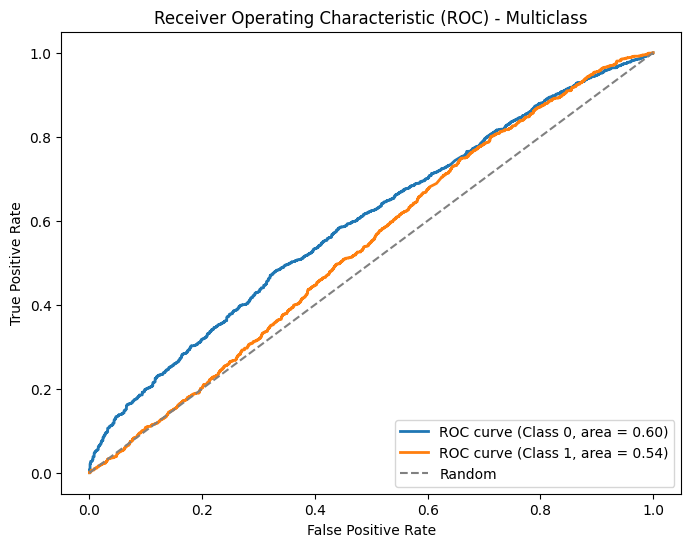

In [ ]:
metrix_model(model_rnn, test_iterator, device, num_classes)

In [ ]:
#test_loss, test_acc = evaluate(model_rnn, test_iterator, criterion, device, num_classes)

## Final model

In [46]:
df = pd.read_json('kinopoisk.jsonl')

# Preprocess the content
df['processed_content'] = df['content'].apply(preprocess_text)
# Закодируем признак grade3
# Удаление строк с меткой 'Neutral'
df = df[df['grade3'] != 'Neutral']
# Преобразование значений в 'grade2'
df['grade2'] = df['grade3'].map({'Bad': 0, 'Good': 1})
print('grade2', df['grade2'].value_counts())
target_dict = {'Bad': 0, 'Good': 1}

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
   df['processed_content'], df['grade2'], test_size=0.2, random_state=42)

grade2 1    27264
0     4751
Name: grade2, dtype: int64


In [47]:
# Create bag of words representation
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

              precision    recall  f1-score   support

           0       0.82      0.81      0.82       935
           1       0.97      0.97      0.97      5468

    accuracy                           0.95      6403
   macro avg       0.89      0.89      0.89      6403
weighted avg       0.95      0.95      0.95      6403

0.9470560674683742


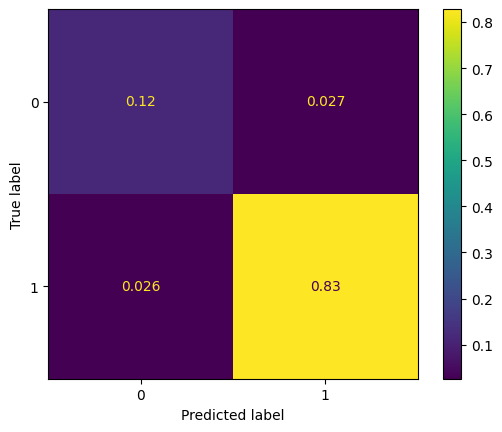

In [57]:
# Train the classifier
logreg_f = LogisticRegression(class_weight='balanced')
logreg_f.fit(X_train_bow, y_train)

# Make predictions
y_pred = logreg_f.predict(X_test_bow)

# Evaluate the model
print(classification_report(y_test, y_pred))

prec, disp =  metrix(logreg_f, X_test_bow, y_test)

## Эксперименты.

запуск сервера:  mlflow ui в директории проектаэ

In [1]:
!python3 taked_script.py

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/leostuchchi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
              precision    recall  f1-score   support

         Bad       0.63      0.65      0.64       979
        Good       0.84      0.97      0.90      5412
     Neutral       0.41      0.02      0.03       928

    accuracy                           0.81      7319
   macro avg       0.62      0.55      0.52      7319
weighted avg       0.76      0.81      0.76      7319

2025/02/16 12:25:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/02/16 12:25:07 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/02/16 12:25:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the mode

In [2]:
!python3 improved.py

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/leostuchchi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
shape (36591, 9)
попуски part             0
movie_name       0
review_id        0
author         789
date             0
title         9119
grade3           0
grade10          0
content          0
dtype: int64
grade3 Good       27264
Bad         4751
Neutral     4576
Name: grade3, dtype: int64
grade2 1    27264
0     4751
Name: grade2, dtype: int64
              precision    recall  f1-score   support

           0       0.80      0.69      0.74       935
           1       0.95      0.97      0.96      5468

    accuracy                           0.93      6403
   macro avg       0.87      0.83      0.85      6403
weighted avg       0.93      0.93      0.93      6403

🏃 View run amusing-shrike-411 at: http://localhost:5000/#/experiments/0/runs/19dc679816a7458c8a6e7fe8bf7e4e99
🧪 View experiment at: http://localhost:5000/#/experiments/0


In [16]:
!python3 research.py

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/leostuchchi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
shape (36591, 9)
попуски part             0
movie_name       0
review_id        0
author         789
date             0
title         9119
grade3           0
grade10          0
content          0
dtype: int64
grade3 Good       27264
Bad         4751
Neutral     4576
Name: grade3, dtype: int64
grade2 1    27264
0     4751
Name: grade2, dtype: int64
              precision    recall  f1-score   support

           0       0.82      0.81      0.82       935
           1       0.97      0.97      0.97      5468

    accuracy                           0.95      6403
   macro avg       0.89      0.89      0.89      6403
weighted avg       0.95      0.95      0.95      6403

🏃 View run worried-ape-890 at: http://localhost:5000/#/experiments/0/runs/db857d2064cb4f2db0480ee660d79b4c
🧪 View experiment at: http://localhost:5000/#/experiments/0


In [20]:
!python3 final_script.py --data_path kinopoisk.jsonl --test_size 0.2 --random_state 42 --vectorizer_type count --model_type naive_bayes

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/leostuchchi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
shape (36591, 9)
попуски part             0
movie_name       0
review_id        0
author         789
date             0
title         9119
grade3           0
grade10          0
content          0
dtype: int64
grade3 Good       27264
Bad         4751
Neutral     4576
Name: grade3, dtype: int64
grade2 1    27264
0     4751
Name: grade2, dtype: int64
              precision    recall  f1-score   support

           0       0.80      0.69      0.74       935
           1       0.95      0.97      0.96      5468

    accuracy                           0.93      6403
   macro avg       0.87      0.83      0.85      6403
weighted avg       0.93      0.93      0.93      6403

2025/02/17 12:57:17 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/02/17 12:57:25 WARNING mlflow.models.model: Model logg

In [19]:
!python3 final_script.py --data_path kinopoisk.jsonl --test_size 0.2 --random_state 42 --vectorizer_type tfidf --model_type naive_bayes

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/leostuchchi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
shape (36591, 9)
попуски part             0
movie_name       0
review_id        0
author         789
date             0
title         9119
grade3           0
grade10          0
content          0
dtype: int64
grade3 Good       27264
Bad         4751
Neutral     4576
Name: grade3, dtype: int64
grade2 1    27264
0     4751
Name: grade2, dtype: int64
/home/leostuchchi/anaconda3/envs/torch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/leostuchchi/anaconda3/envs/torch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined 

In [18]:
!python3 final_script.py --data_path kinopoisk.jsonl --test_size 0.2 --random_state 42 --vectorizer_type count --model_type logistic

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/leostuchchi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
shape (36591, 9)
попуски part             0
movie_name       0
review_id        0
author         789
date             0
title         9119
grade3           0
grade10          0
content          0
dtype: int64
grade3 Good       27264
Bad         4751
Neutral     4576
Name: grade3, dtype: int64
grade2 1    27264
0     4751
Name: grade2, dtype: int64
              precision    recall  f1-score   support

           0       0.82      0.81      0.82       935
           1       0.97      0.97      0.97      5468

    accuracy                           0.95      6403
   macro avg       0.89      0.89      0.89      6403
weighted avg       0.95      0.95      0.95      6403

2025/02/17 11:33:20 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/02/17 11:33:26 WARNING mlflow.models.model: Model logg

In [28]:
!mlflow run .

^C

Aborted!


In [27]:
!mlflow run . --env-manager=local # в локальном окружении
# !mlflow run . # в conda.yaml

^C

Aborted!


## Результаты и выводы.

In [54]:
print('Метрики полученого скрипта')

# Evaluate the model
print(classification_report(y_test_f, y_pred_f))

Метрики полученого скрипта
              precision    recall  f1-score   support

         Bad       0.63      0.66      0.64       979
        Good       0.84      0.97      0.90      5412
     Neutral       0.38      0.02      0.03       928

    accuracy                           0.81      7319
   macro avg       0.62      0.55      0.52      7319
weighted avg       0.75      0.81      0.76      7319



In [59]:
print('Метрики финальной модели balanced')

# Evaluate the model
print(classification_report(y_test, y_pred))

Метрики финальной модели balanced
              precision    recall  f1-score   support

           0       0.82      0.81      0.82       935
           1       0.97      0.97      0.97      5468

    accuracy                           0.95      6403
   macro avg       0.89      0.89      0.89      6403
weighted avg       0.95      0.95      0.95      6403



In [56]:
target_dict

{'Bad': 0, 'Good': 1}


    Precision (точность):

Для класса 0: 0.87 означает, что 87% из всех предсказанных положительных классов (0) действительно являются положительными.
        
Для класса 1: 0.96 говорит о том, что 96% из всех предсказанных положительных классов (1) действительно являются положительными.

В среднем (macro avg): 0.91, что указывает на высокую точность для обоих классов.

    Recall (полнота):

Для класса 0: 0.75 означает, что модель правильно распознала 75% всех истинных положительных классов (0).

Для класса 1: 0.98 говорит о том, что 98% всех истинных положительных классов (1) были правильно идентифицированы.

В среднем (macro avg): 0.87, что также указывает на неплохие результаты, хотя полнота для класса 0 могла бы быть выше.

    F1-score:

Для класса 0: 0.81, это хорошее значение, но можно стремиться к улучшению.

Для класса 1: 0.97, что говорит о том, что модель хорошо справляется с этим классом.

В среднем (macro avg): 0.89, что также указывает на сбалансированное качество модели по обоим классам.

    Accuracy (точность):

Общая точность модели составляет 0.95, что является отличным результатом, указывающим на то, что 95% предсказаний модели были верными.

    Macro avg и weighted avg:
        
Macro average учитывает метрики для каждого класса одинаково, что может быть полезно при анализе несбалансированных данных.

Weighted average учитывает количество примеров в каждом классе, что дает более точное представление о производительности модели в условиях несбалансированных данных.


# Резюме:

Финальная модель показывает значительно лучшие результаты по всем метрикам по сравнению с полученным скриптом. Это указывает на улучшение как в области точности, так и в полноте предсказаний, что делает финальную модель более надежной для применения в реальных задачах классификации.

In [60]:
print('Метрики полученого скрипта')
# Evaluate the model
print(classification_report(y_test_f, y_pred_f))
print('Метрики финальной модели balanced')
# Evaluate the model
print(classification_report(y_test, y_pred))

Метрики полученого скрипта
              precision    recall  f1-score   support

         Bad       0.63      0.66      0.64       979
        Good       0.84      0.97      0.90      5412
     Neutral       0.38      0.02      0.03       928

    accuracy                           0.81      7319
   macro avg       0.62      0.55      0.52      7319
weighted avg       0.75      0.81      0.76      7319

Метрики финальной модели balanced
              precision    recall  f1-score   support

           0       0.82      0.81      0.82       935
           1       0.97      0.97      0.97      5468

    accuracy                           0.95      6403
   macro avg       0.89      0.89      0.89      6403
weighted avg       0.95      0.95      0.95      6403



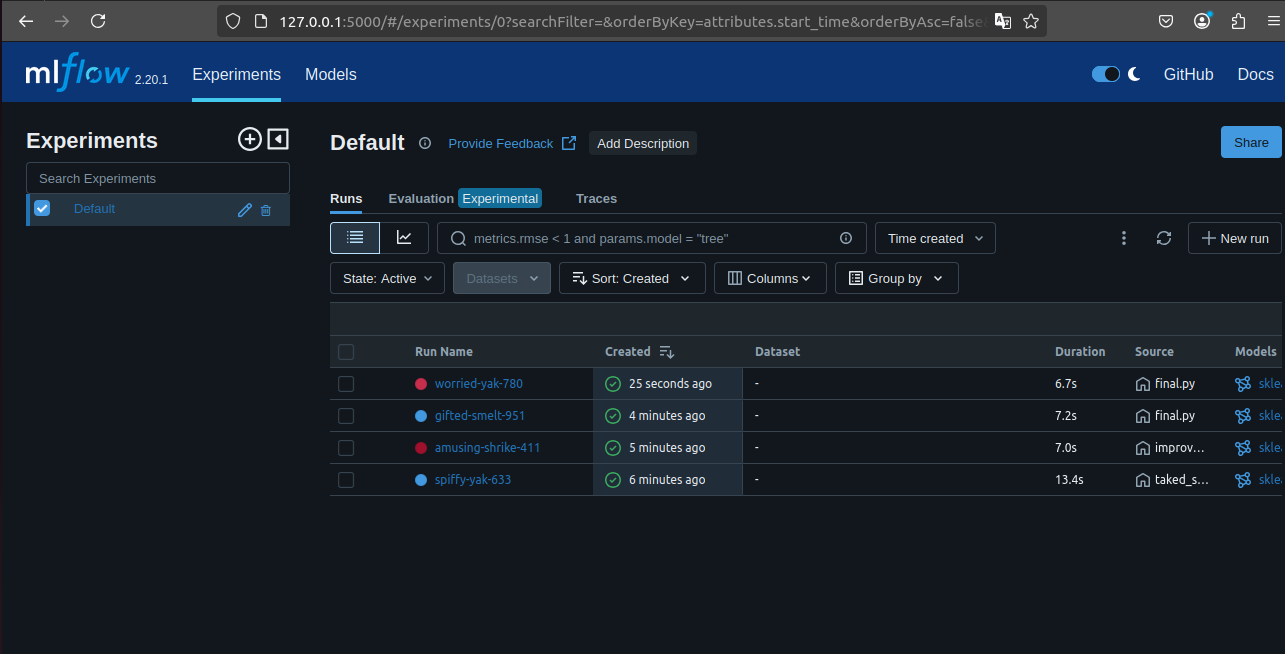

In [5]:
from IPython.display import Image, display

# файл изображения
image_path = 'Screen_1.png' 

# Отображение изображения
display(Image(filename=image_path))

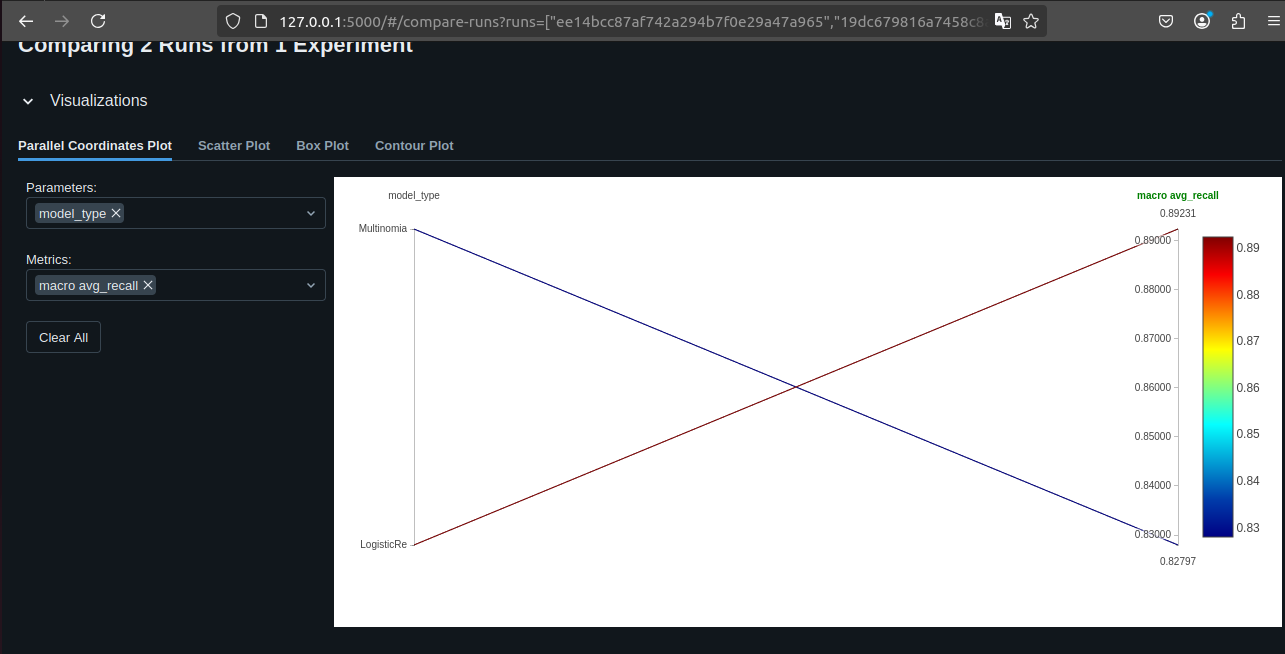

In [6]:
# файл изображения
image_path = 'Screen_2.png' 

# Отображение изображения
display(Image(filename=image_path))

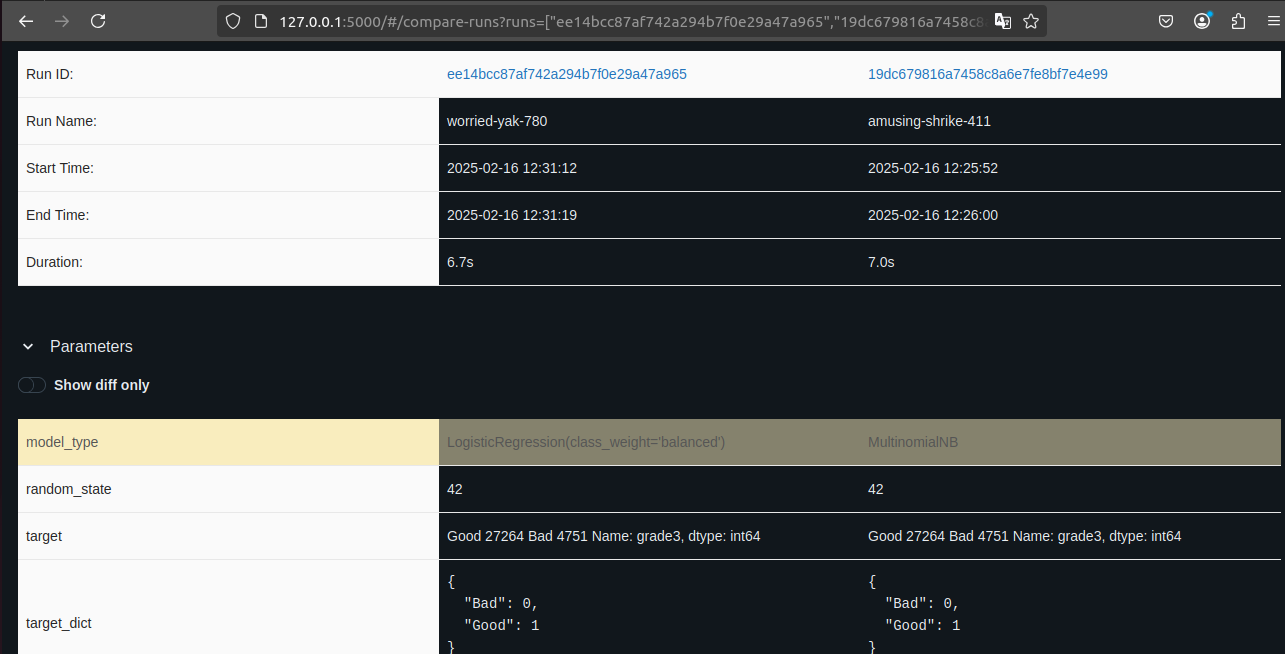

In [7]:
# файл изображения
image_path = 'Screen_3.png' 

# Отображение изображения
display(Image(filename=image_path))

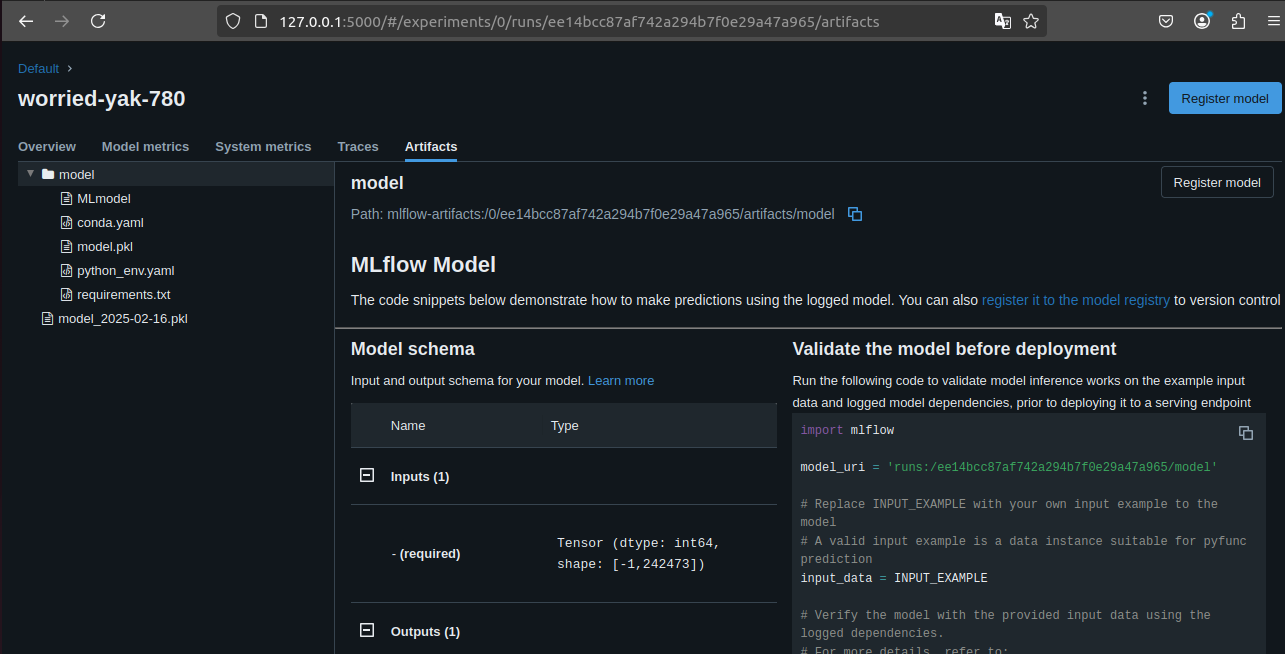

In [8]:
# файл изображения
image_path = 'Screen_4.png' 

# Отображение изображения
display(Image(filename=image_path))

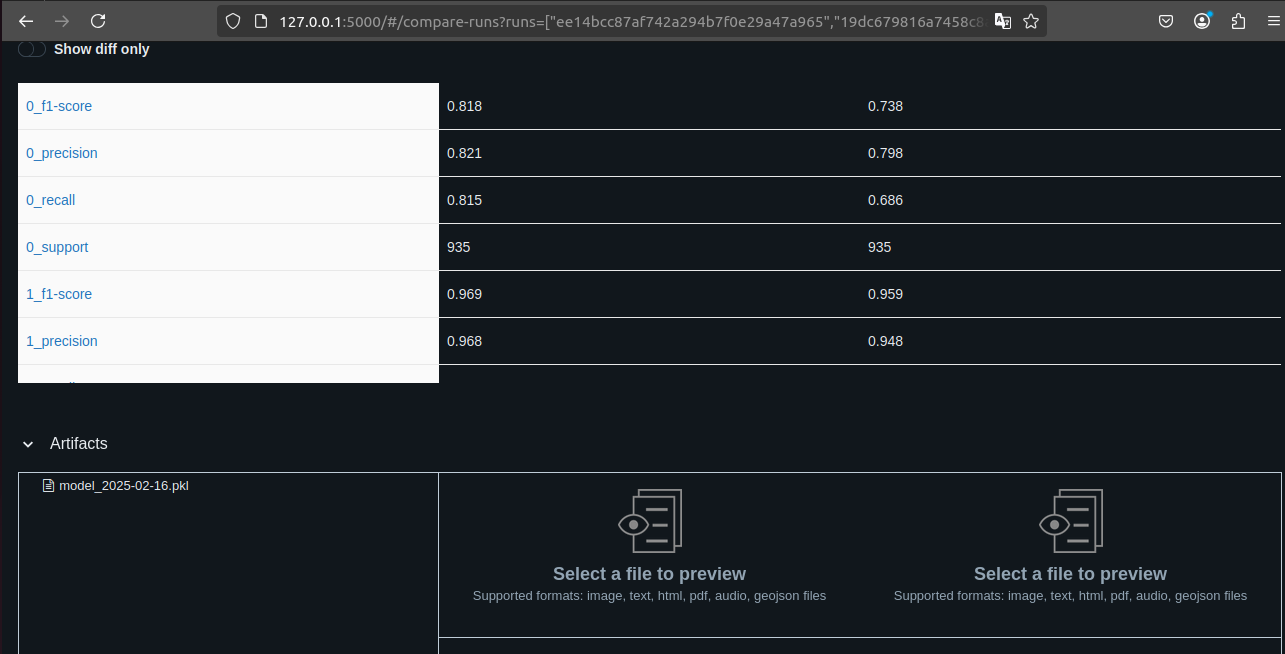

In [9]:
# файл изображения
image_path = 'Screen_5.png' 

# Отображение изображения
display(Image(filename=image_path))

Финальная модель показывает значительно лучшие результаты по всем метрикам по сравнению с полученным скриптом. Это указывает на улучшение как в области точности, так и в полноте предсказаний, что делает финальную модель более надежной для применения в реальных задачах классификации.